In [1]:
try:
    import torch
    from torch import nn
    from torch.utils.data import DataLoader

    import torchvision
    from torchvision import transforms
    from torchvision import datasets

    import torchmetrics

    import matplotlib.pyplot as plt
except:
    !pip install torch
    !pip install torchvision
    !pip install matplotlib
    !pip install torchmetrics
    
    import torch
    from torch import nn
    from torch.utils.data import DataLoader

    import torchvision
    from torchvision import transforms
    from torchvision import datasets

    import matplotlib.pyplot as plt

In [2]:
#making code dvice agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(torch.__version__)

2.0.1


In [4]:
from pathlib import Path
TRAINING_SET_PATH = Path('datasets/training_set')
TEST_SET_PATH = Path('datasets/test_set')

TRAINING_SET_PATH, TEST_SET_PATH

(PosixPath('datasets/training_set'), PosixPath('datasets/test_set'))

In [5]:
#importing the datasets from torchvision.datasets
train_data = datasets.MNIST(
    root=TRAINING_SET_PATH,
    download=True,
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root=TEST_SET_PATH,
    train=False, #testset
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets/training_set
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
len(train_data[0])

2

In [8]:
train_data[0][1]

5

In [9]:
image, label = train_data[0]

In [10]:
label

5

In [11]:
#to get the dimension of an image
image.shape

torch.Size([1, 28, 28])

Image is black and white

In [12]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [13]:
len(train_data.targets)

60000

In [14]:
len(test_data.targets)

10000

In [15]:
class_names = train_data.classes
class_names[1]
class_names[label]

'5 - five'

In [16]:
image.shape

torch.Size([1, 28, 28])

In [17]:
image.squeeze().shape

torch.Size([28, 28])

#### were working with `60000` train data samples and `10000` test data samples

>## visualizing

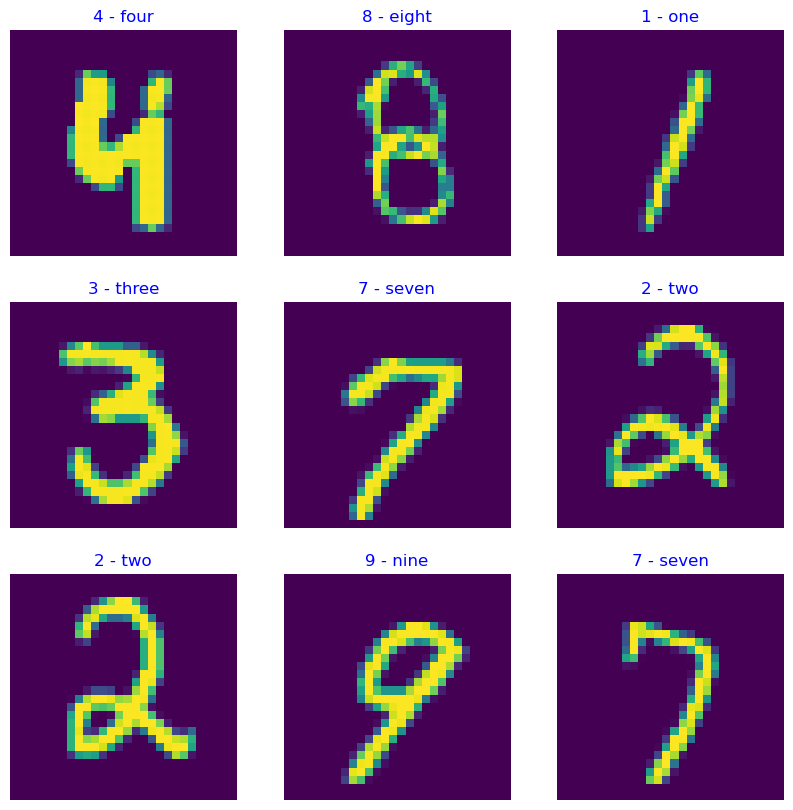

In [18]:
#visualizing
sample_grid = plt.figure(figsize=(10,10))
rows, cols = 3, 3
for i in range (1,rows*cols+1):
    random_no = torch.randint(0,len(train_data), size=[1]).item()
    image, label = train_data[random_no]
    sample_grid.add_subplot(rows, cols, i)
    plt.axis(False)
    plt.title(class_names[label], c='b')
    plt.imshow(image.squeeze()) #we need to squeeze as matplotlib only takes in 2d
    

In [19]:
rand = torch.rand(size=(1,))
rand.item()

0.6937690377235413

In [20]:
rand1 = torch.randint(0, len(train_data),size=[1])
rand1.item()

44803

>## loading data

In [21]:
BATCH_SIZE = 32 #const

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE 
)

len(train_dataloader), len(test_dataloader)


(1875, 313)

In [22]:
32*1875

60000

In [23]:
len(train_data)

60000

In [24]:
X_train_batch, y_train_batch = next(iter(train_dataloader))
X_train_batch.shape, y_train_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [25]:
X_train_batch[0].shape

torch.Size([1, 28, 28])

In [26]:
len(X_train_batch)

32

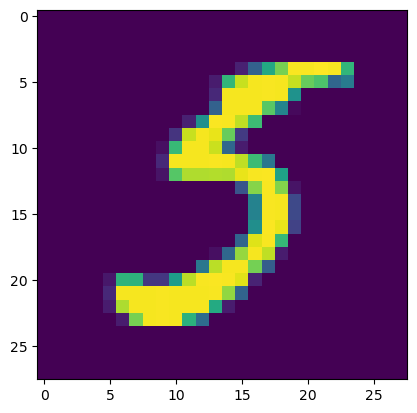

In [27]:
#random train image visual
random_no2 = torch.randint(0, len(X_train_batch), size=[1]).item()
plt.imshow(X_train_batch[random_no2].squeeze())

>## Model ARch

In [28]:
class MNISTModelV1(nn.Module):
    """
    TinyVGG model Arch.
    mddel from CNN explainers website https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            #create a conv layer
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #values wew can set ourselfs are called hyperparameters called nn conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)          
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
                     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,#there is a trick to calculate this!
                      out_features=output_shape),
            
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # print("output shape fp conv layer 2",x.shape) #use this to get dim of in features in classification layer
        x = self.classifier(x)
        return x


In [29]:
#pass rand_tensor of similar dims into model to get dim after nn.flatten()
rand_image_tensor = torch.randn(size=(1,28,28))
model_1 = MNISTModelV1(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_1(rand_image_tensor.unsqueeze(dim=0).to(device=device))

tensor([[ 0.0305,  0.1323, -0.0695,  0.0487, -0.0476, -0.0062, -0.0229,  0.0230,
         -0.1183,  0.0365]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
                y_pred.argmax(dim=1),# Go from logits -> pred labels wihout softmax
                y 
            ).item()*100
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    return train_loss, train_acc



In [31]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                test_pred.argmax(dim=1),# Go from logits -> pred labels wihout softmax
                y 
            ).item()*100
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        
    return test_loss, test_acc

In [32]:
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-0.2807,  0.0255, -0.0797],
                        [ 0.1296,  0.2547,  0.1461],
                        [-0.0811,  0.2714,  0.2407]]],
              
              
                      [[[ 0.1242, -0.2114,  0.1161],
                        [-0.0743, -0.1118, -0.3135],
                        [-0.1891, -0.2415, -0.1766]]],
              
              
                      [[[-0.0953,  0.2702, -0.2407],
                        [-0.2327,  0.0976, -0.1312],
                        [-0.3306,  0.2905,  0.0196]]],
              
              
                      [[[-0.0064,  0.0681, -0.0805],
                        [-0.1969, -0.2151,  0.1569],
                        [ 0.3309,  0.1907, -0.1801]]],
              
              
                      [[[-0.1017, -0.2038, -0.1396],
                        [-0.2166, -0.0505,  0.2183],
                        [ 0.1542, -0.1177, -0.0212]]],
              
              
      

In [33]:
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [34]:
from torchmetrics import Accuracy
acc = Accuracy(task='multiclass',
               num_classes=len(class_names)).to(device)

In [35]:
len(class_names)

10

In [36]:
#import helper file
import requests
from pathlib import Path
#downloading helper_functions.py
if Path('helper_functions.py').is_file():
    print('helper_fcuntions.py already exists, skipping download..')
else:
    print("downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as file:
        file.write(request.content)

helper_fcuntions.py already exists, skipping download..


In [37]:
from timeit import default_timer as Timer
from tqdm.auto import tqdm
import helper_functions 

start_timer = Timer()
train_loss_values = []
train_acc_values = []
test_acc_values = []
test_loss_values = []
epochs = 3 #low for testing
for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n--------")
    train_loss_list, train_acc_list = train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc,
        device=device
    )

    test_loss_list, test_acc_list = test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=acc,
              device=device)
    train_loss_values.append(train_loss_list.item())
    train_acc_values.append(train_acc_list)
    test_loss_values.append(test_loss_list.item())
    test_acc_values.append(test_acc_list)
    
end_timer = Timer()
total_time = helper_functions.print_train_time(start=start_timer,
                                               end=end_timer,
                                               device=device)

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
--------
Train loss: 0.22212 | Train accuracy: 93.02%


 33%|███▎      | 1/3 [00:16<00:33, 16.88s/it]

Test loss: 0.08084 | Test accuracy: 97.54%

epoch: 1
--------
Train loss: 0.06957 | Train accuracy: 97.90%


 67%|██████▋   | 2/3 [00:35<00:17, 17.70s/it]

Test loss: 0.04663 | Test accuracy: 98.46%

epoch: 2
--------
Train loss: 0.05266 | Train accuracy: 98.41%


100%|██████████| 3/3 [00:53<00:00, 18.00s/it]

Test loss: 0.03567 | Test accuracy: 98.96%


Train time on cuda: 53.999 seconds


In [38]:
train_loss_values

[0.22212029993534088, 0.06956955045461655, 0.052662819623947144]

In [39]:
train_acc_values

[93.01666666666667, 97.89666666666666, 98.41]

In [40]:
test_acc_values

[97.54392971246007, 98.46246006389777, 98.96166134185303]

In [41]:
test_loss_values

[0.08083896338939667, 0.04662838950753212, 0.03566758707165718]

>## plotting the loss and acc graph

In [42]:
train_results = {
    "train_loss": train_loss_values,
    "train_acc": train_acc_values,
    "test_loss": test_loss_values,
    "test_acc": test_acc_values
}

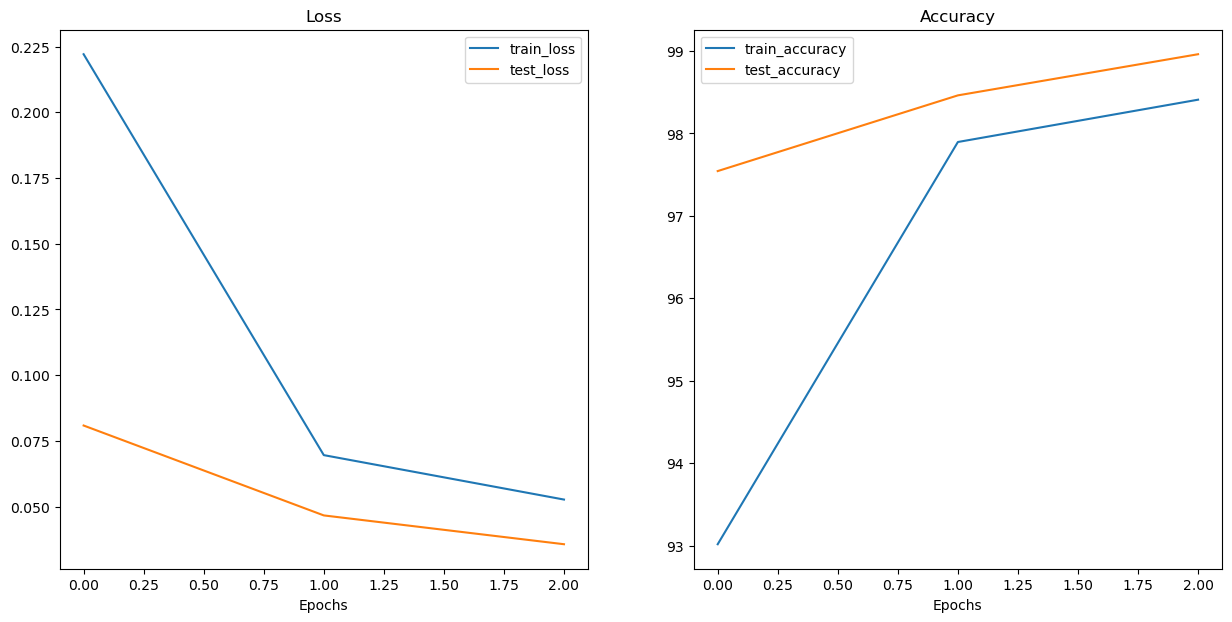

In [43]:
helper_functions.plot_loss_curves(train_results)